In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
import os

True

In [15]:
load_dotenv()

os.environ['LANGSMITH_API_KEY'] = os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING']="true"

In [ ]:
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [5]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama-3.3-70b-versatile")

In [6]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x739fe0694550>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x739fe066fe80>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
from langchain_tavily import TavilySearch
search_tool = TavilySearch(max_results=2)

In [27]:
def add(a:int,b:int):
    ''' Add two numbers'''
    return a+b

In [34]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode([search_tool,add])
llm_with_tools = llm.bind_tools([search_tool,add])

In [35]:
from langgraph.graph import StateGraph,START,END
def should_continue(state:State):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [36]:
def agent_node(state:State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages":response}

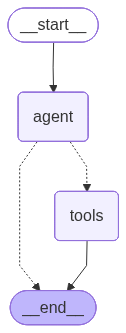

In [37]:

builder = StateGraph(State)

builder.add_node("agent",agent_node)
builder.add_node("tools",tool_node)
builder.add_edge(START,"agent")
builder.add_conditional_edges(
    "agent",
    should_continue,
    ["tools",END]
)
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
out = graph.invoke(
    {"messages":"What is 50 + 100"}
)
out

{'messages': [HumanMessage(content='What is 50 + 100', additional_kwargs={}, response_metadata={}, id='a70f353a-d3fa-492b-b7e9-eaf69e33fe9e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'b5g974as8', 'function': {'arguments': '{"a":50,"b":100}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 1832, 'total_tokens': 1850, 'completion_time': 0.047886509, 'completion_tokens_details': None, 'prompt_time': 0.093295439, 'prompt_tokens_details': None, 'queue_time': 0.057366959, 'total_time': 0.141181948}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--f113359e-f21c-4958-a7a4-d0eee6123cdb-0', tool_calls=[{'name': 'add', 'args': {'a': 50, 'b': 100}, 'id': 'b5g974as8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1832, 'output_tokens': 18, 'total_token

In [39]:
out['messages'][-1].content

'150'